<a href="https://colab.research.google.com/github/Kurtiadam/speedcam_cvs/blob/main/OCR_tryings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install easyocr
!pip install imutils

!gdown https://drive.google.com/uc?id=1DlSijY3W4TVgQ0u7WOoAR062dZGU9ZqZ
!gdown https://drive.google.com/uc?id=1h68_ujBlyFWElTKJkyfSQaRNQ7fD86nM

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (3,284 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

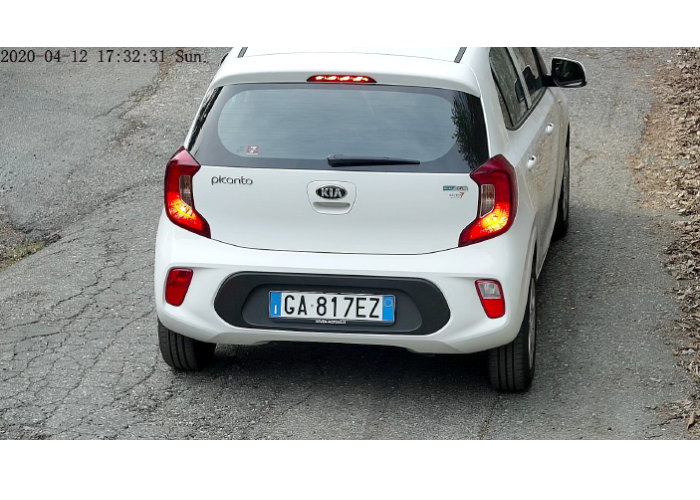

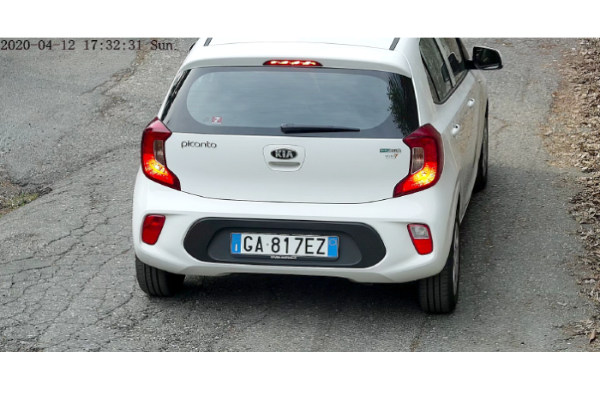

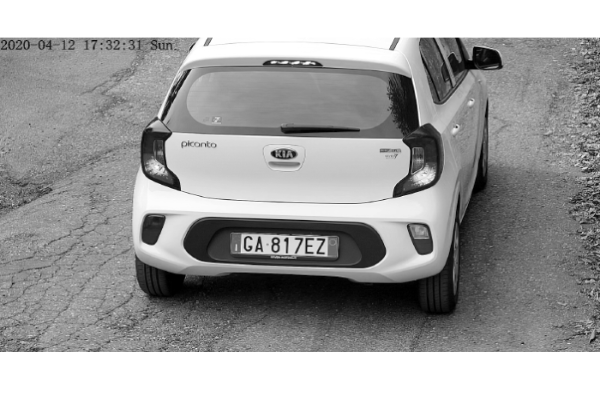

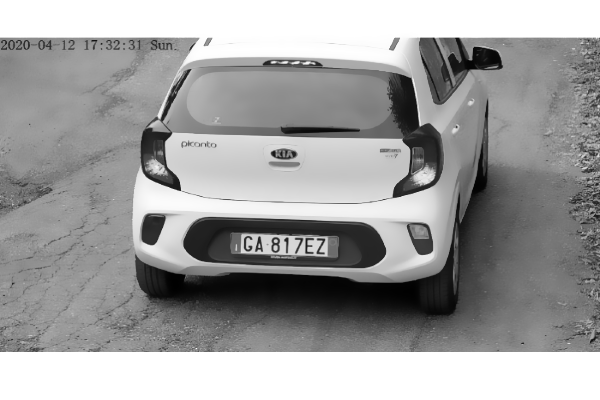

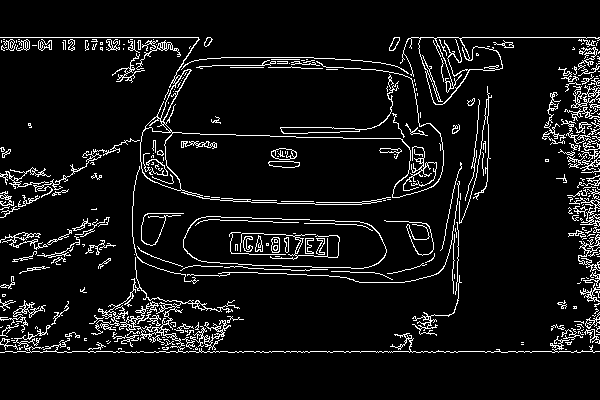

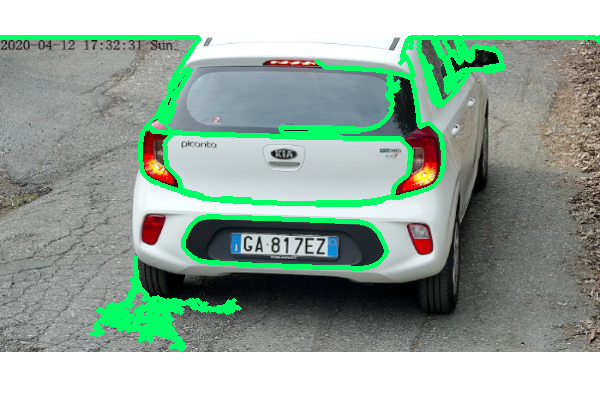

error: ignored

In [2]:
import cv2
import imutils
import easyocr
import pytesseract
import numpy as np
from PIL import Image, ImageFilter
from google.colab.patches import cv2_imshow

#Reading the image     
original_image = cv2.imread('/content/RH-BCC1-LPR_giorno_post_md.png')
cv2_imshow(original_image)

resized_image = cv2.resize(original_image,(600, 400))   # change image size into 600*400
cv2_imshow(resized_image)

gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # convert the image into grayscale
cv2_imshow(gray)

#Plate detection
#Apply bilater filter for noise reduction and finf edges
bfilter = cv2.bilateralFilter(gray, 13, 15, 15)  # apply bilateral filter for Noise reduction
cv2_imshow(bfilter)
edged = cv2.Canny(bfilter, 30, 200)  # Edge detection
cv2_imshow(edged)

#Finding counturs
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)

# arrange contours descending based on contour area and get largest 10
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  
image1 = resized_image.copy()
# drawing the identified contours on our image
cv2.drawContours(image1,contours,-1,(100,255,0),3)
cv2_imshow(image1)

plate_location = None
for contour in contours:
  epsilon =  0.018*cv2.arcLength(contour, True)  # Ratio of contour Perimeter 
  approx = cv2.approxPolyDP(contour, epsilon, True)  # approximate contour shape 
  
  if len(approx) == 4:
    plate_location = approx
    break

plate_location

image2 = resized_image.copy()
# drawing the plate contour on our image
cv2.drawContours(image2,[plate_location],-1,(100,255,0),3)
cv2_imshow(image2)

#Masking
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [plate_location], -1, 255, -1)
new_image = cv2.bitwise_and(resized_image, resized_image, mask=mask)

cv2_imshow(new_image)

(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]
cv2_imshow(cropped_image)

#APPLY OCR
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
data = pytesseract.image_to_string(cropped_image, lang='eng', config='--psm 8')
print(data)
blur = cv2.GaussianBlur(cropped_image, (3,3), 0)
cv2_imshow(blur)
thresh = cv2.threshold(cropped_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)

# Morph open to remove noise and invert image
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
# cv2_imshow(opening)
invert = 255 - thresh  #opening 
cv2_imshow(invert)

data = pytesseract.image_to_string(invert, lang='eng', config='--psm 8')

print(data)

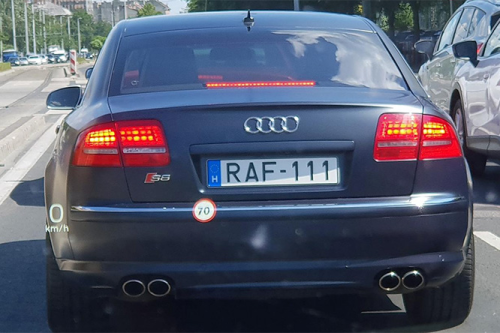

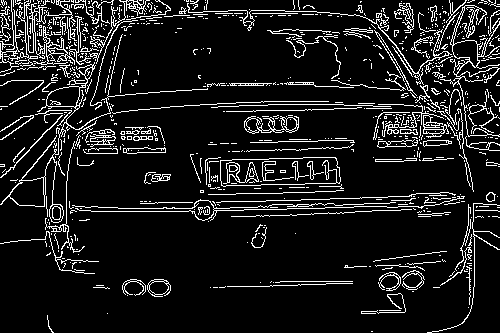

error: ignored

In [10]:
import numpy as np
import cv2
import  imutils
import sys
import pytesseract
import pandas as pd
import time

image = cv2.imread('/content/car.jpg')

image = imutils.resize(image, width=500)

cv2_imshow(image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cv2.imshow("1 - Grayscale Conversion", gray)

gray = cv2.bilateralFilter(gray, 11, 17, 17)
#cv2.imshow("2 - Bilateral Filter", gray)

edged = cv2.Canny(gray, 50, 50)
cv2_imshow(edged)

(new, cnts) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] 
NumberPlateCnt = None 

count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  
            NumberPlateCnt = approx 
            break

# Masking the part other than the number plate
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[NumberPlateCnt],0,255,-1)
new_image = cv2.bitwise_and(image,image,mask=mask)
cv2.namedWindow("Final_image",cv2.WINDOW_NORMAL)
cv2_imshow("Final_image",new_image)

# Configuration for tesseract
config = ('-l eng --oem 1 --psm 3')

# Run tesseract OCR on image
text = pytesseract.image_to_string(new_image, config=config)

#Data is stored in CSV file
raw_data = {'date': [time.asctime( time.localtime(time.time()) )], 
        'v_number': [text]}

df = pd.DataFrame(raw_data, columns = ['date', 'v_number'])
df.to_csv('data.csv')

# Print recognized text
print(text)

cv2.waitKey(0)